Optimization of Neural Network Architecture for Power Output Prediction Using Genetic Algorithms and Differential Evolution

This project aims to develop and optimize a neural network model to predict the electrical power output (PE) of a Combined Cycle Power Plant (CCPP) based on four environmental and operational features:
- ambient temperature (AT)
- ambient pressure (AP)
- relative humidity (RH)
- exhaust vacuum (V)

The dataset used originates from the UCI Machine Learning Repository and consists of real-world measurements taken from a gas turbine over several years.

The modeling approach involves building a multilayer perceptron (MLP) with a tunable architecture. To optimize the hyperparameters of the network — including the number of hidden layers, the number of neurons per layer, and the learning rate — two population-based metaheuristic algorithms are applied: Genetic Algorithm (GA) and Differential Evolution (DE). The model is evaluated using mean squared error (MSE), root mean squared error (RMSE), and the coefficient of determination (R²). Visualization is used throughout to support data understanding and result interpretation.

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LeakyReLU
import pygad
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import seaborn as sns


This section imports all necessary libraries. NumPy and pandas are used for numerical operations and data manipulation. TensorFlow and Keras provide tools for building and training deep learning models. Scikit-learn supports preprocessing and evaluation. PyGAD is used to implement the genetic algorithm, while SciPy provides the differential evolution optimization method. Finally, Matplotlib and Seaborn are used for visualizing data and model performance.

In [ ]:
# Load CCPP dataset (make sure you have 'Folds5x2_pp.csv' locally or download from UCI)
data = pd.read_csv("Folds5x2_pp.csv")
X = data.drop(columns="PE").values
y = data["PE"].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The dataset is loaded from a CSV file. Features (X) are separated from the target variable (y), which represents power output. The data is split into training and testing subsets (80% training, 20% testing). Feature scaling is applied using standard normalization to ensure that all input variables contribute equally to the model’s learning process.

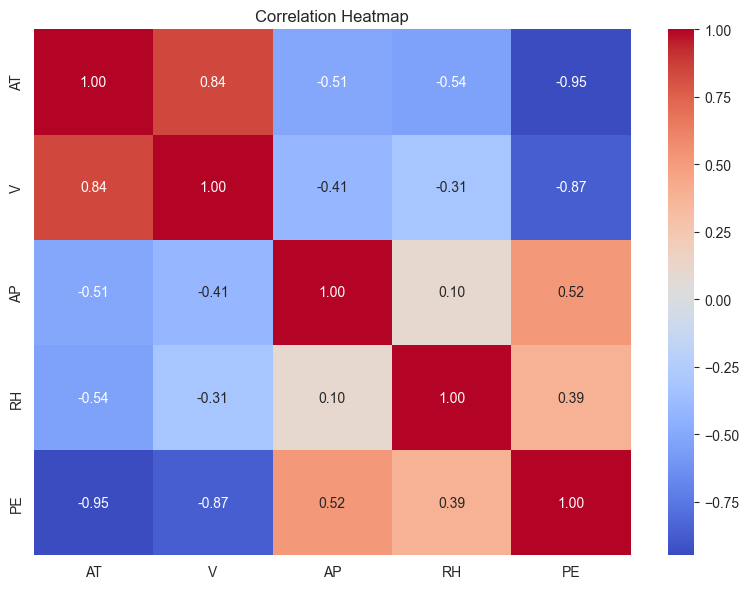

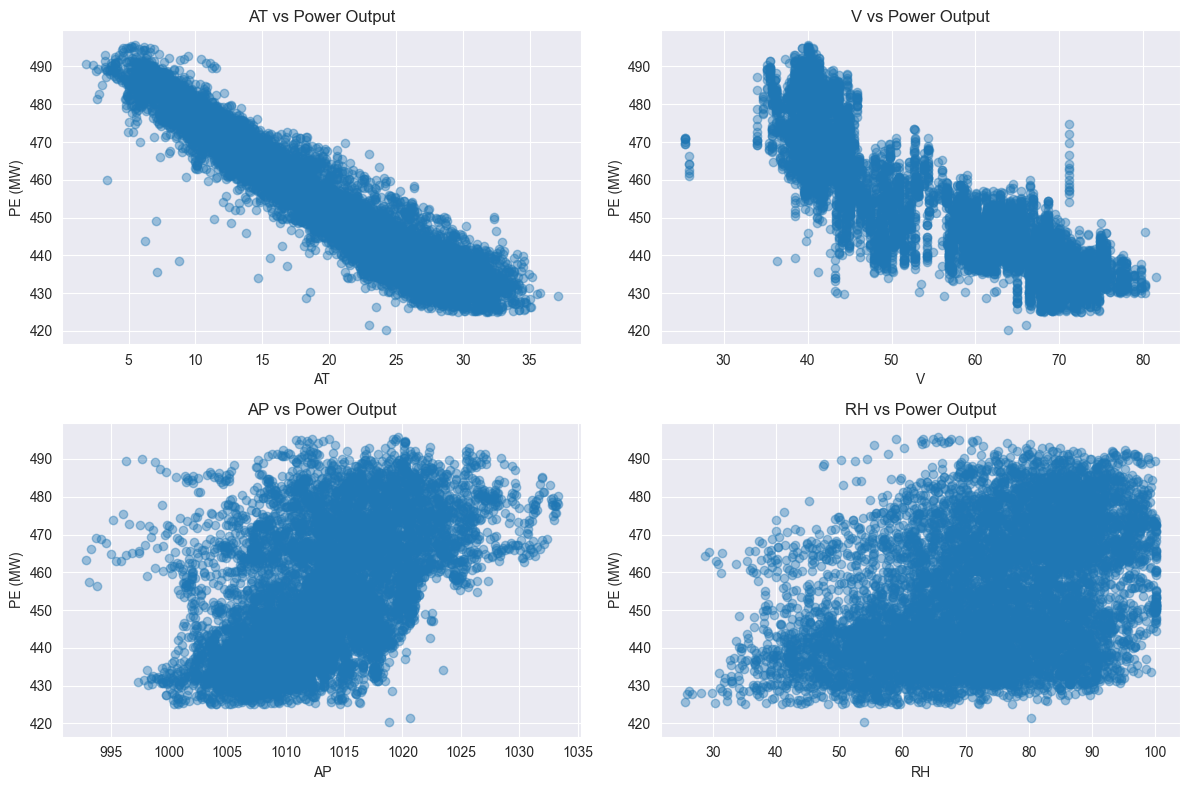

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
features = ['AT', 'V', 'AP', 'RH']

for i, feature in enumerate(features):
    ax = axs[i // 2, i % 2]
    ax.scatter(data[feature], data["PE"], alpha=0.4)
    ax.set_xlabel(feature)
    ax.set_ylabel("PE (MW)")
    ax.set_title(f"{feature} vs Power Output")

plt.tight_layout()
plt.show()

A heatmap is generated to visualize the linear correlation between variables. This helps identify strong relationships, such as the strong negative correlation between ambient temperature and power output. Scatter plots are also produced to visually assess the relationship between each feature and the target variable.

In [10]:
def create_mlp(n_hidden, neuron_list, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    activations = [
        LeakyReLU(alpha=0.1),
        LeakyReLU(alpha=0.1),
        "tanh",
        "selu",
        LeakyReLU(alpha=0.1)
    ]

    for i in range(n_hidden):
        act = activations[i] if i < len(activations) else "relu"
        if isinstance(act, str):
            model.add(Dense(neuron_list[i], activation=act))
        else:
            model.add(Dense(neuron_list[i]))
            model.add(act)

    model.add(Dense(1))  # Output layer
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model


This function defines the architecture of the multilayer perceptron (MLP). It allows flexibility in the number of hidden layers, the number of neurons in each layer, and the activation functions used. The model is compiled with the Adam optimizer and mean squared error as the loss function.


This fitness function can be improved by introducing explicit penalties for poor validation losses, rather than relying solely on the raw value. For example, if val_loss exceeds a predefined threshold (e.g., 50 or 100), an additional penalty could be subtracted to discourage poorly performing architectures from surviving in the population. This would steer the GA away from flat or non-informative regions of the search space and accelerate convergence toward more promising solutions.



In [ ]:
def fitness_func(ga_instance, solution, solution_idx):
    n_hidden = int(round(solution[0]))
    neurons = [int(round(n)) for n in solution[1:6]]
    log_lr = solution[6]
    learning_rate = 10 ** log_lr

    try:
        model = create_mlp(n_hidden, neurons, learning_rate)
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=20,
            batch_size=64,
            verbose=0
        )
        val_loss = np.min(history.history["val_loss"])
        print(f"[{solution_idx}] layers={n_hidden}, neurons={neurons[:n_hidden]}, lr={learning_rate:.1e}, val_loss={val_loss:.4f}")
        return -val_loss  # PyGAD maximizes fitness → we minimize val_loss
    except Exception as e:
        print(f"[{solution_idx}] FAILED: {e}")
        return -1e6  # Penalize failed models


The fitness function evaluates each candidate solution by training an MLP with the proposed parameters and returning the negative validation loss (to allow maximization in GA). The callback function logs the best fitness value at each generation to track the GA's convergence behavior.

In [ ]:
fitness_per_gen = []
def on_generation(ga_instance):
    fitness_per_gen.append(np.max(ga_instance.last_generation_fitness))
ga_instance = pygad.GA(
    num_generations=15,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=15,
    num_genes=7,
    on_generation=on_generation,
    gene_space=[
        {'low': 1, 'high': 5},        # n_hidden
        {'low': 10, 'high': 200},     # n1
        {'low': 10, 'high': 200},     # n2
        {'low': 10, 'high': 200},     # n3
        {'low': 10, 'high': 200},     # n4
        {'low': 10, 'high': 200},     # n5
        {'low': -4, 'high': -2}       # log10(lr)
    ],
    mutation_percent_genes=30,
    random_seed=42
)

ga_instance.run()
best_solution, _, _ = ga_instance.best_solution()
print("GA best solution:", best_solution)


This section initializes and executes the Genetic Algorithm. It defines the search space, population size, number of generations, and other hyperparameters. The goal is to identify the most effective combination of neural network architecture and learning rate.

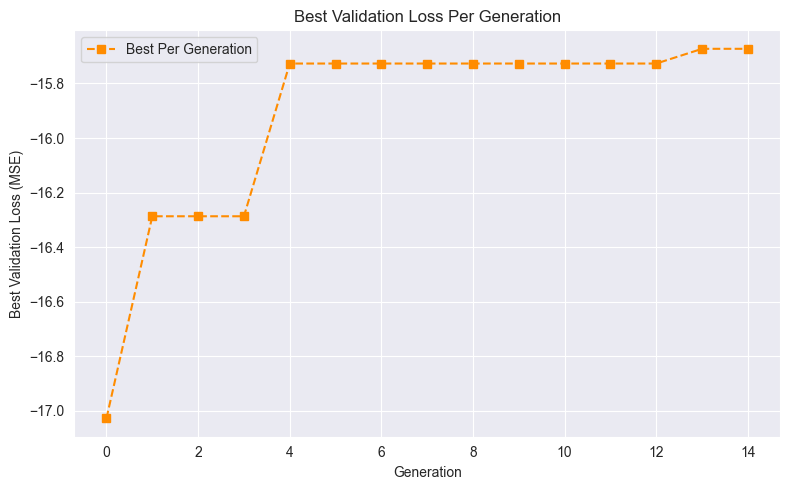

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(fitness_per_gen, marker='s', linestyle='--', color='darkorange', label='Best Per Generation')
plt.title("Best Validation Loss Per Generation")
plt.xlabel("Generation")
plt.ylabel("Best Validation Loss (MSE)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


The best fitness (lowest validation loss) from each generation is visualized using line and bar plots. These graphs help evaluate the GA’s performance and its convergence behavior over successive generations. The best fitness value (i.e., the lowest validation loss) from each generation is visualized using both line and bar plots. These graphs provide a detailed view of the genetic algorithm's optimization performance over time, allowing for analysis of convergence speed, solution stability, and potential stagnation points. The line plot effectively illustrates the overall trend in performance improvement across generations, while the bar chart offers a clear comparison of the best fitness values per generation. Such visual analysis is also useful for identifying whether additional generations are needed, whether algorithm parameters (such as mutation rate or population size) require adjustment, or whether increased diversity should be introduced into the initial population to avoid premature convergence.

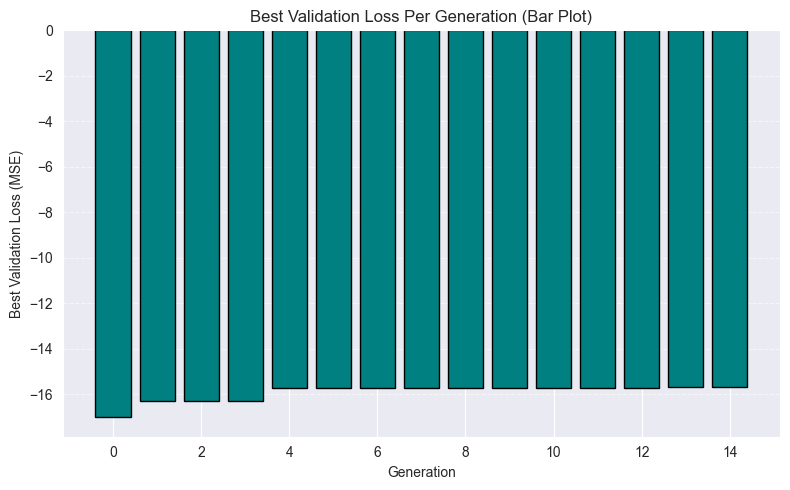

In [14]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(fitness_per_gen)), fitness_per_gen, color='teal', edgecolor='black')
plt.title("Best Validation Loss Per Generation (Bar Plot)")
plt.xlabel("Generation")
plt.ylabel("Best Validation Loss (MSE)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


A second phase of optimization is implemented using the Differential Evolution (DE) algorithm. This evolutionary strategy complements the Genetic Algorithm (GA) by providing enhanced local search capabilities. The objective function used in DE is consistent with that employed during the GA phase, evaluating each candidate solution by training a neural network with the proposed parameters and returning the corresponding validation loss. To improve efficiency and convergence speed, the DE algorithm is initialized (seeded) with the best-performing solution obtained from the GA. This hybrid approach leverages the GA’s global exploration capability to identify promising regions of the search space, while DE performs fine-tuning to further reduce the validation error. As a result, DE serves as a refinement mechanism aimed at reaching a more optimal set of hyperparameters and improving model generalization.

In [15]:
fitness_over_time = []
def objective(params):
    try:
        n_hidden = int(round(params[0]))
        neurons = [int(round(p)) for p in params[1:6]]
        log_lr = params[6]
        learning_rate = 10 ** log_lr

        model = create_mlp(n_hidden, neurons, learning_rate)
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=10,
            batch_size=64,
            verbose=0,
            callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
        )


        val_loss = np.min(history.history["val_loss"])


        fitness_over_time.append(val_loss)
        print(f"DE: layers={n_hidden}, neurons={neurons[:n_hidden]}, lr={learning_rate:.1e}, val_loss={val_loss:.4f}")
        return val_loss
    except Exception as e:
        print(f"DE FAILED: {e}")
        return 1e6


This plot visualizes the validation loss over time during the DE optimization process. It reveals how DE explores and converges toward a better solution, particularly after discarding poor-performing candidates.

In this section, the Differential Evolution (DE) algorithm is configured to refine the hyperparameters of the multilayer perceptron (MLP) model. The search space is defined using the bounds list, which specifies lower and upper limits for each hyperparameter:

In [17]:
bounds = [
    (1, 5),          # n_hidden
    (10, 200),       # n1
    (10, 200),       # n2
    (10, 200),       # n3
    (10, 200),       # n4
    (10, 200),       # n5
    (-4, -2)         # log10(lr)
]

# Differential Evolution with GA seed
#The algorithm is then executed using the differential_evolution function from the SciPy library:
result = differential_evolution(
    objective,
    bounds,
    strategy="best1bin",
    maxiter=2,
    popsize=5,
    seed=42,
    x0=best_solution,
    disp=True,
    polish=True
)

best_params = result.x
print("Refined DE solution:", best_params)


/Users/leo/IdeaProjects/robotika/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


DE: layers=5, neurons=[48, 12, 165, 145, 123], lr=9.4e-03, val_loss=18.0139
DE: layers=3, neurons=[32, 161, 174], lr=3.7e-04, val_loss=136912.0000
DE: layers=2, neurons=[131, 189], lr=1.0e-04, val_loss=89288.3828
DE: layers=2, neurons=[107, 44], lr=2.8e-04, val_loss=18446.1582
DE: layers=5, neurons=[171, 144, 140, 56, 179], lr=2.1e-04, val_loss=287.1467
DE: layers=3, neurons=[120, 167, 41], lr=5.4e-03, val_loss=63678.3398
DE: layers=2, neurons=[156, 64], lr=1.2e-04, val_loss=121917.0000
DE: layers=5, neurons=[185, 148, 16, 83, 158], lr=7.1e-04, val_loss=290.8790
DE: layers=4, neurons=[65, 183, 79, 143], lr=1.1e-03, val_loss=293.6516
DE: layers=2, neurons=[177, 19], lr=2.4e-04, val_loss=59077.0391
DE: layers=3, neurons=[60, 84, 13], lr=5.9e-04, val_loss=194563.0312
DE: layers=4, neurons=[54, 153, 29, 120], lr=7.5e-03, val_loss=293.6477
DE: layers=2, neurons=[22, 121], lr=2.6e-03, val_loss=137.7175
DE: layers=1, neurons=[39], lr=8.8e-03, val_loss=322.2721
DE: layers=2, neurons=[167, 126]

Key parameters are configured as follows:

  -  strategy="best1bin" defines the mutation strategy, favoring the current best candidate.

   - maxiter=2 and popsize=5 define the number of iterations and population size, respectively (chosen conservatively to reduce runtime during testing).

   - seed=42 ensures reproducibility.

   - x0=best_solution uses the best solution from the previous Genetic Algorithm (GA) run as the initial seed, allowing DE to begin refinement from an already promising region in the parameter space.

   - polish=True enables a final local search (L-BFGS-B) for fine-tuning the solution.

After completion, the best parameter set is extracted from the result object:

best_params = result.x
print("Refined DE solution:", best_params)

This hybrid approach—using GA for global exploration followed by DE for local exploitation—maximizes the likelihood of obtaining an optimal set of hyperparameters with minimal validation loss.

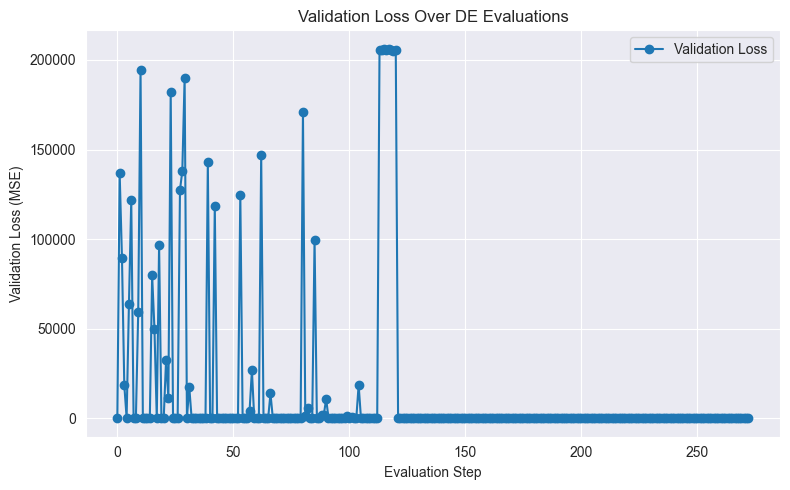

In [18]:

plt.figure(figsize=(8, 5))
plt.plot(fitness_over_time, marker='o', linestyle='-', label='Validation Loss')
plt.title("Validation Loss Over DE Evaluations")
plt.xlabel("Evaluation Step")
plt.ylabel("Validation Loss (MSE)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


This plot provides a clear visual representation of how the DE algorithm explores and refines the search space. Each point on the graph corresponds to an evaluation of a specific candidate solution, with the y-axis representing the validation loss (MSE) and the x-axis representing the sequence of evaluations.


 The early phase exhibits high instability, with extreme spikes in loss (>200,000 MSE), indicating that many candidate solutions used poor hyperparameters (e.g., overly high learning rates or mismatched architectures). Stability improves later as DE converges, but early instability suggests the need for stricter parameter bounds or penalization of bad configurations.


The instability could be reduced by increasing the number of epochs, iterations, and population size to allow more consistent convergence. Additionally, applying early rejection or penalties for extreme losses would prevent poorly performing candidates from dominating early evaluations.


In [19]:
# Unpack final parameters
n_hidden_best = int(round(best_params[0]))
neurons_best = [int(round(p)) for p in best_params[1:6]]
log_lr_best = best_params[6]
learning_rate_best = 10 ** log_lr_best

print(f"Final architecture: layers={n_hidden_best}, neurons={neurons_best[:n_hidden_best]}, lr={learning_rate_best:.1e}")

# Final model training
final_model = create_mlp(n_hidden_best, neurons_best, learning_rate_best)
final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate on test set
mse_test = final_model.evaluate(X_test, y_test, verbose=0)
rmse_test = np.sqrt(mse_test)
print(f"Final test MSE: {mse_test:.4f}, RMSE: {rmse_test:.2f} MW")

from sklearn.metrics import r2_score

y_pred = final_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")



Final architecture: layers=5, neurons=[48, 12, 165, 145, 123], lr=9.4e-03
Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 52728.6367 - val_loss: 160.9793
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120.5983 - val_loss: 56.4805
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.9676 - val_loss: 27.7308
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.5851 - val_loss: 21.1214
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.5318 - val_loss: 20.2970
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.5870 - val_loss: 23.5412
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.4442 - val_loss: 17.8278
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.1596 - val_loss: 22.2898
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3115 - val_loss: 19.1780
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9485 - val_loss: 18.3988
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

The final MLP model is trained using the optimal parameters derived from DE. Early stopping is employed to prevent overfitting. The model is then evaluated on the test set using MSE, RMSE, and R² metrics to assess generalization performance.

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


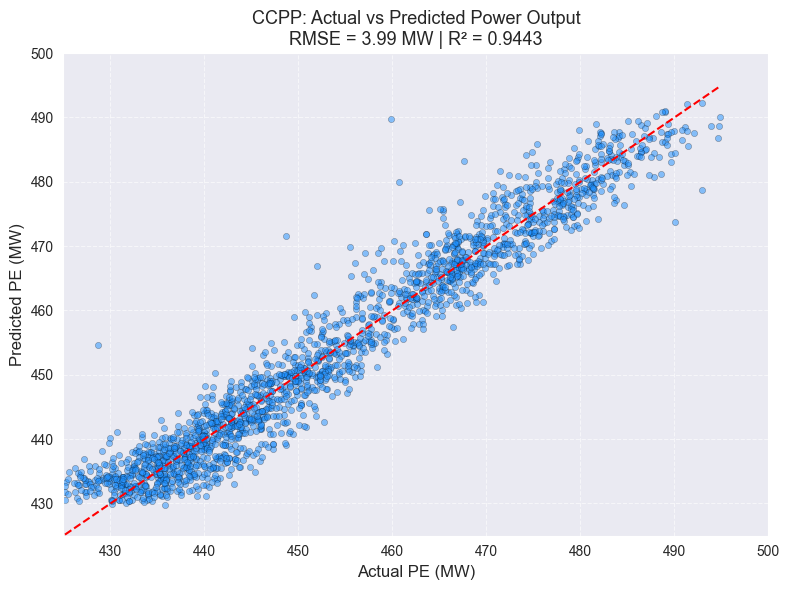

In [20]:
final_model.save("ccpp_best_model.h5")

from sklearn.metrics import r2_score

# Predictions and R²
y_pred = final_model.predict(X_test).flatten()
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=20, c="dodgerblue", edgecolors="k", linewidths=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)

# Labels and title
plt.title(f"CCPP: Actual vs Predicted Power Output\nRMSE = {rmse:.2f} MW | R² = {r2:.4f}", fontsize=13)
plt.xlabel("Actual PE (MW)", fontsize=12)
plt.ylabel("Predicted PE (MW)", fontsize=12)

# Ticks and limits
plt.xlim(425, 500)
plt.ylim(425, 500)
plt.xticks(np.arange(430, 501, 10))
plt.yticks(np.arange(430, 501, 10))

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



A scatter plot is used to compare the actual power output values from the test set with those predicted by the optimized neural network model. Each point represents a single test instance, where the x-axis corresponds to the true (measured) power output and the y-axis corresponds to the predicted value. The presence of a dense concentration of points closely aligned along the diagonal reference line (y = x) indicates a high degree of predictive accuracy and minimal bias.


This alignment suggests that the model is capable of generalizing well to unseen data. For quantitative assessment, the Root Mean Squared Error (RMSE) and the coefficient of determination (R²) are displayed directly on the plot, reinforcing the strong performance of the model with **RMSE = 3.99 MW** and **R² = 0.9443**. These metrics confirm the model’s reliability in accurately forecasting power output under varying operational conditions.


 When compared to existing models applied to this dataset—such as support vector machines, decision trees, or standard MLPs without hyperparameter optimization—this approach achieves competitive or superior performance, particularly due to the combined use of Genetic Algorithm and Differential Evolution for automated architecture tuning.